# Spaceship Titanic - Feature Engineering
---

This notebook will create new columns and handle midding data.

## Imports

### Libraries

In [69]:
import pandas as pd 
import numpy as np
import pickle 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

### Data

In [70]:
train_data_full = pd.read_csv('../data/train.csv')
test_data_full = pd.read_csv('../data/test.csv')

## New Columns

There are a few clear directions that the contest wants us to go to create new columns such as splitting the passengerID and cabin. They also created multiple different spending columns and purposely grouped them in the data descriptipn. Other than this, there may be some columns which have strong associations with Transported at certain value ranges.

In [71]:
train = train_data_full.copy()
test = test_data_full.copy()


### Split PassengerId

It is given that the passengerID is in the from group_groupnumber, I'm going to split them into these columns

In [72]:
# Train set
train['group'] = [x.split('_')[0] for x in train.PassengerId]
train['group_num'] = [x.split('_')[1] for x in train.PassengerId]

# Test set
test['group'] = [x.split('_')[0] for x in test.PassengerId]
test['group_num'] = [x.split('_')[1] for x in test.PassengerId]


### Group Sizes

Now that we have a group column, we can determine the number of passengers in each group

I'm going to use the full data set to determine this, it will be interesting to see how this strategy compares to imputing without the test data. 

In [73]:
full = pd.concat([train, test])

In [74]:
train['group_size'] = [full['group'].value_counts()[x] for x in train['group']]

In [75]:
test['group_size'] = [full['group'].value_counts()[x] for x in test['group']]

<Axes: xlabel='group_size', ylabel='count'>

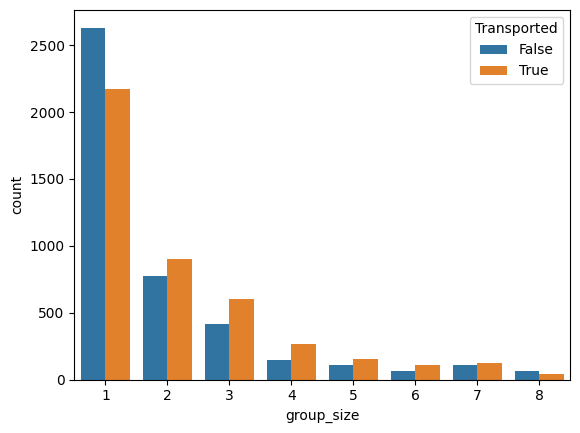

In [76]:
sns.countplot(data=train, x='group_size', hue='Transported')

Solo is much more likley to survive than larger groups so I'm goin to make an isSolo column.

### Solo Column


In [77]:
train['is_solo'] = train['group_size'] == 1
test['is_solo'] = test['group_size'] == 1

### Split Cabin 

The contest was also very clear that cabin should be split into deck/num/side.

In [78]:
train['Cabin'].isnull().value_counts()

Cabin
False    8494
True      199
Name: count, dtype: int64

Because there are missing Cabin values, I'm going to fill them with large numbers that can be easily removed later so I can split the rest of the data.

In [79]:
train['Cabin'].fillna('9999/9999/9999', inplace=True)
test['Cabin'].fillna('9999/9999/9999', inplace= True)

/tmp/ipykernel_1793/3951784324.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Cabin'].fillna('9999/9999/9999', inplace=True)
/tmp/ipykernel_1793/3951784324.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [80]:
train['cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['cabin_num'] = train['Cabin'].apply(lambda x: x.split('/')[1])
train['cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

test['cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['cabin_num'] = test['Cabin'].apply(lambda x: x.split('/')[1])
test['cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

Now I'm going to replace each of the 9999s with null.

In [81]:
train.loc[train['cabin_deck'] == '9999', 'cabin_deck'] = np.nan
train.loc[train['cabin_num'] == '9999', 'cabin_num'] = np.nan
train.loc[train['cabin_side'] == '9999', 'cabin_side'] = np.nan

test.loc[test['cabin_deck'] == '9999', 'cabin_deck'] = np.nan
test.loc[test['cabin_num'] == '9999', 'cabin_num'] = np.nan
test.loc[test['cabin_side'] == '9999', 'cabin_side'] = np.nan


### Total Spending

In [82]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train['spending'] = train[spending_cols].sum(axis=1)
test['spending'] = test[spending_cols].sum(axis=1)

<Axes: xlabel='spending', ylabel='Count'>

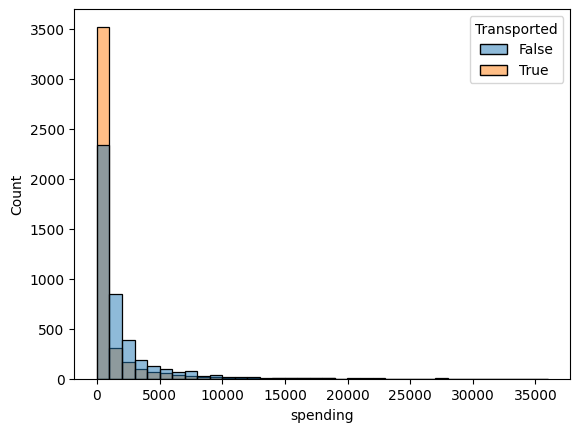

In [83]:
sns.histplot(data=train, x='spending', hue='Transported', binwidth=1000)

People who spent little to no money were transported much more so I'm going to add a no_spending column.

In [84]:
train[train['spending'] == 0].shape

(3653, 22)

In [85]:
train['spent_nothing'] = train['spending'] == 0
test['spent_nothing'] = test['spending'] == 0

In [86]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,group,group_num,group_size,is_solo,cabin_deck,cabin_num,cabin_side,spending,spent_nothing
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0001,01,1,True,B,0,P,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,0002,01,1,True,F,0,S,736.0,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0003,01,2,False,A,0,S,10383.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0003,02,2,False,A,0,S,5176.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,0004,01,1,True,F,1,S,1091.0,False


### Age Groups

<Axes: xlabel='Age', ylabel='Count'>

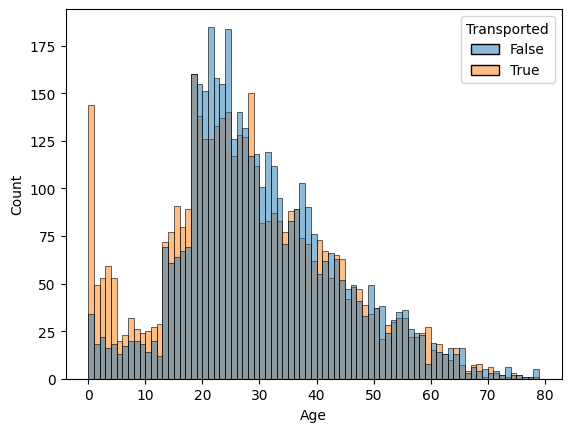

In [87]:
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1)

There is a huge disparity in transportation by age. There are specific patterns in children under 5 years old,  under 13, and under 18.

In [88]:
train['under_5'] = train['Age'] < 5
train['under_13'] = train['Age'] < 13
train['under_18'] = train['Age'] < 18

test['under_5'] = test['Age'] < 5
test['under_13'] = test['Age'] < 13
test['under_18'] = test['Age'] < 18

In [89]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,group_size,is_solo,cabin_deck,cabin_num,cabin_side,spending,spent_nothing,under_5,under_13,under_18
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1,True,B,0,P,0.0,True,False,False,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1,True,F,0,S,736.0,False,False,False,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,2,False,A,0,S,10383.0,False,False,False,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,2,False,A,0,S,5176.0,False,False,False,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,True,F,1,S,1091.0,False,False,False,True


## Handling Missing

### Home Planet

In [90]:
train.groupby(['cabin_deck', 'HomePlanet']).HomePlanet.value_counts()

cabin_deck  HomePlanet
A           Europa         252
B           Europa         766
C           Europa         734
D           Europa         186
            Mars           282
E           Earth          395
            Europa         128
            Mars           330
F           Earth         1614
            Mars          1110
G           Earth         2498
T           Europa           4
Name: count, dtype: int64

In [91]:
europa_decks = ['A', 'B', 'C', 'T']
earth_deck = ['G']

In [92]:
train[train.HomePlanet.isnull()].shape

(201, 26)

In [93]:
train.loc[train.HomePlanet.isnull() & train.cabin_deck.isin(europa_decks), 'HomePlanet'] = 'Europa'
train.loc[train.HomePlanet.isnull() & train.cabin_deck.isin(earth_deck), 'HomePlanet'] = 'Earth'


In [94]:
train[train.HomePlanet.isnull()].shape

(109, 26)

31 missing HomePlanets were filled in train

In [95]:
test[test.HomePlanet.isnull()].shape

(87, 25)

In [96]:
test.loc[test.HomePlanet.isnull() & test.cabin_deck.isin(europa_decks), 'HomePlanet'] = 'Europa'
test.loc[test.HomePlanet.isnull() & test.cabin_deck.isin(earth_deck), 'HomePlanet'] = 'Earth'

In [97]:
test[test.HomePlanet.isnull()].shape

(51, 25)

Missing by Group

In [98]:
group_home_planets = train.groupby(['group', 'HomePlanet']).HomePlanet.size().unstack()

In [99]:
group_home_planets.loc['0001',group_home_planets.loc['0001'].notnull()].index[0]

'Europa'

In [100]:
((group_home_planets > 0).sum(axis = 1) > 1).value_counts()

False    6155
Name: count, dtype: int64

All groups have the same home planet.

I didnt have time to impute home planet by group.

I'm going to impute the rest with mode.

In [101]:
train['HomePlanet'].fillna('Earth', inplace=True)
test['HomePlanet'].fillna('Earth', inplace=True)

/tmp/ipykernel_1793/2727837131.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['HomePlanet'].fillna('Earth', inplace=True)
/tmp/ipykernel_1793/2727837131.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [102]:
test[test.HomePlanet.isnull()].shape ,train[train.HomePlanet.isnull()].shape

((0, 25), (0, 26))

All HomePlanets are filled

### Cryo Sleep

I'm going to assume missing values are false.

In [103]:
train['CryoSleep'].fillna(False, inplace=True)
test['CryoSleep'].fillna(False, inplace=True)

/tmp/ipykernel_1793/909738778.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['CryoSleep'].fillna(False, inplace=True)
/tmp/ipykernel_1793/909738778.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['CryoSleep'].fillna(False, inplace=True)
/tmp/ipykernel_1793/909738778.py:2: FutureWarning: A v

In [104]:
train[train['CryoSleep'].isnull()].shape, test[test['CryoSleep'].isnull()].shape

((0, 26), (0, 25))

### Destination

I'm going to use the most common destinations.

In [105]:
train[train.Destination.isnull()].shape, test[test.Destination.isnull()].shape

((182, 26), (92, 25))

In [106]:
train['Destination'].fillna(train['Destination'].mode()[0], inplace=True)
test['Destination'].fillna(test['Destination'].mode()[0], inplace=True)

/tmp/ipykernel_1793/2967433817.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Destination'].fillna(train['Destination'].mode()[0], inplace=True)
/tmp/ipykernel_1793/2967433817.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [107]:
train[train.Destination.isnull()].shape,test[test.Destination.isnull()].shape

((0, 26), (0, 25))

### Missing Age

I'm going to impute with the median age.

In [108]:
train[train.Age.isnull()].shape,test[test.Age.isnull()].shape

((179, 26), (91, 25))

In [109]:
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

/tmp/ipykernel_1793/3278935906.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/tmp/ipykernel_1793/3278935906.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [110]:
train[train.Age.isnull()].shape,test[test.Age.isnull()].shape

((0, 26), (0, 25))

### VIP

I'm assuming missing VIP is going to be false.

In [111]:
train[train.VIP.isnull()].shape,test[test.VIP.isnull()].shape

((203, 26), (93, 25))

In [112]:
train['VIP'].fillna(False, inplace=True)
test['VIP'].fillna(False, inplace=True)

/tmp/ipykernel_1793/4291798221.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['VIP'].fillna(False, inplace=True)
/tmp/ipykernel_1793/4291798221.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['VIP'].fillna(False, inplace=True)
/tmp/ipykernel_1793/4291798221.py:2: FutureWarning: A value is t

In [113]:
train[train.VIP.isnull()].shape,test[test.VIP.isnull()].shape

((0, 26), (0, 25))

### Spending

For all spending categories I'm going to fill missing with 0's.

In [114]:
for col in spending_cols:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)

/tmp/ipykernel_1793/3450522941.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(0, inplace=True)
/tmp/ipykernel_1793/3450522941.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

### Name

I'm going to drop the names column.

In [115]:
train.drop(columns=['Name'], inplace=True)
test.drop(columns=['Name'], inplace=True)

### Missing Cabin Data

I'm just going to fill each missing value with the mode from that column.

In [116]:
train['cabin_deck'].fillna(train['cabin_deck'].mode()[0], inplace=True)
test['cabin_deck'].fillna(test['cabin_deck'].mode()[0], inplace=True)

/tmp/ipykernel_1793/3115627642.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['cabin_deck'].fillna(train['cabin_deck'].mode()[0], inplace=True)
/tmp/ipykernel_1793/3115627642.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [117]:
train['cabin_side'].fillna(train['cabin_side'].mode()[0], inplace=True)
test['cabin_side'].fillna(test['cabin_side'].mode()[0], inplace=True)

/tmp/ipykernel_1793/3848240249.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['cabin_side'].fillna(train['cabin_side'].mode()[0], inplace=True)
/tmp/ipykernel_1793/3848240249.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [118]:
train['cabin_num'].fillna(train['cabin_num'].mode()[0], inplace=True)
test['cabin_num'].fillna(test['cabin_num'].mode()[0], inplace=True)

/tmp/ipykernel_1793/1923813307.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['cabin_num'].fillna(train['cabin_num'].mode()[0], inplace=True)
/tmp/ipykernel_1793/1923813307.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [119]:
train.isnull().any()

PassengerId      False
HomePlanet       False
CryoSleep        False
Cabin            False
Destination      False
Age              False
VIP              False
RoomService      False
FoodCourt        False
ShoppingMall     False
Spa              False
VRDeck           False
Transported      False
group            False
group_num        False
group_size       False
is_solo          False
cabin_deck       False
cabin_num        False
cabin_side       False
spending         False
spent_nothing    False
under_5          False
under_13         False
under_18         False
dtype: bool

In [120]:
test.isnull().any()

PassengerId      False
HomePlanet       False
CryoSleep        False
Cabin            False
Destination      False
Age              False
VIP              False
RoomService      False
FoodCourt        False
ShoppingMall     False
Spa              False
VRDeck           False
group            False
group_num        False
group_size       False
is_solo          False
cabin_deck       False
cabin_num        False
cabin_side       False
spending         False
spent_nothing    False
under_5          False
under_13         False
under_18         False
dtype: bool

There are now no null values in the datasets.

## Imputing Categorical Data

### Passenger ID

I'm going to drop passenger Id

In [121]:
train.drop(columns=['PassengerId'], inplace=True)
test.drop(columns=['PassengerId'], inplace=True)

### Cabin

Cabin can be dropped because it was split up.

In [122]:
train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

### Boolean Columns

All bool columns will be 1s and 0s

In [123]:
bool_cols = ['CryoSleep', 'VIP', 'is_solo', 'spent_nothing', 'under_5', 'under_13', 'under_18']

In [124]:
train[bool_cols] = train[bool_cols].astype(int)
test[bool_cols] = test[bool_cols].astype(int)

### Group 

group and group num can be changed to ints.

In [125]:
train['group'] = train['group'].astype(int)
test['group'] = test['group'].astype(int)
train['group_num'] = train['group_num'].astype(int)
test['group_num'] = test['group_num'].astype(int)

### One Hot Encoding

In [126]:
object_cols = ['cabin_side', 'cabin_deck', 'Destination', 'HomePlanet']

In [127]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)


# Create One Hot columns for categorical data

oh_cols_train = pd.DataFrame(encoder.fit_transform(train[object_cols]))
oh_cols_test = pd.DataFrame(encoder.transform(test[object_cols]))

# Put index back in

oh_cols_test.index = test.index
oh_cols_train.index = train.index

# Remove Categorical

num_train = train.drop(columns=object_cols, axis=1)
num_test = test.drop(columns=object_cols, axis=1)

# Add OH Cols

OH_train = pd.concat([num_train, oh_cols_train], axis=1)
OH_test= pd.concat([num_test, oh_cols_test], axis=1)

# cols as string

OH_train.columns = OH_train.columns.astype(str)

OH_test.columns = OH_test.columns.astype(str)



Now the data is ready to be used for predictions.

## Pickling

In [128]:
with open('../pickles/train_modified_1.pkl', 'wb') as f:
    pickle.dump(OH_train, f)

In [129]:
with open('../pickles/test_modified_1.pkl', 'wb') as f:
    pickle.dump(OH_test, f)